# Классификация комментариев

Необходимо составить модель, классифицирующую комментарии на позитивные и негативные.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

Сделал это проект на локальной машине, потому что хаб постоянно умирал. Прямо замучался. 

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

Загрузим комментарии

In [2]:
comments = pd.read_csv('./datasets/toxic_comments.csv')

In [3]:
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
comments[comments['toxic']==1].head()

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


In [5]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
comments.duplicated().sum() # проверим есть ли дубликаты 

0

0    143346
1     16225
Name: toxic, dtype: int64


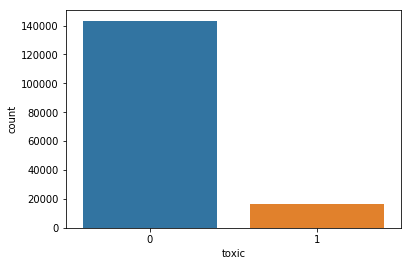

In [7]:
print(comments['toxic'].value_counts())
sns.countplot(comments['toxic']);

## Вывод

Итак, у нас есть 159571 комментариев, 16225 из которых помечены как негативные. Перед нами стоит задача бинарной классификации. 

# 2. Обучение

Для начала необходимо произвести подготовку данных, отчистить и лемматизировать тексты. Напишем для этого функцию. (Используя при этом библиотеку nltk). 

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
def clear_and_lemmatize(text):
    review_text = re.sub("[^a-zA-Z]"," ", text)
    words = word_tokenize(review_text.lower())
    lemma_words = [lemmatizer.lemmatize(i) for i in words]
    lemm_text = " ".join(lemma_words)        
    return lemm_text

Применим функцию к датасету. 

In [10]:
comments['lemmatized'] = comments['text'].apply(clear_and_lemmatize)

In [11]:
comments['lemmatized'].head()

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestion on impro...
4    you sir are my hero any chance you remember wh...
Name: lemmatized, dtype: object

___

Итак, у нас есть лемматизированный текст. Существуют разные подходы к созданию фичей для предсказания тональности текста. Опробуем некоторые из них, предварительно разделив выборку на тренировочную и тестовую части. При этом важно, чтобы не допустить утечки данных из тестовой части выполнить разделение заранее. Тестовые данные будут составлять 20% от исходных. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(comments['lemmatized'], comments['toxic'], test_size=0.2, random_state=42)

In [13]:
stopwords = set(stopwords.words('english'))

___

1. Мешок слов

Создадим словарь всех слов тренировочной выборки при помощи CountVectorizer

In [14]:
count_v = CountVectorizer(stop_words=stopwords)

In [15]:
corpus_train = X_train.values.astype('U')
corpus_test = X_test.values.astype('U')

In [16]:
corpus_train[40]

'i could have opinion and theory about his mother but i don t go around posting them'

In [17]:
%%time
count_train = count_v.fit_transform(corpus_train)

Wall time: 8.06 s


Посмотрим на длинну получившегося словаря. 

In [18]:
len(count_v.vocabulary_)

138845

In [19]:
print(count_v.get_feature_names()[:50])
print(count_v.get_feature_names()[50000:50050])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany', 'aaaaaaaaaah', 'aaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaaadm', 'aaaaaaaaaq', 'aaaaaaaacfo', 'aaaaaaaaczy', 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 'aaaaaaaari', 'aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh', 'aaaaaaw', 'aaaaah', 'aaaah', 'aaaannnnyyyywwwwhhhheeeerrrreeee', 'aaaawwww', 'aaaboyz', 'aaages', 'aaaghh', 'aaah', 'aaahhh', 'aaahs', 'aaai', 'aaajade', 'aaand', 'aaarrrgggh', 'aaaww', 'aab', 'aaberg', 'aabove', 'aac', 'aacargo', 'aacd', 'aachen', 'aachi', 'aad', 'aadd', 'aademia', 'aadil', 'aadmi', 'aadministrators', 'aadu', 'aae', 'aaets', 'aaf', 'aaffect']
['granita', 'granite', 'granitethigh', 'granitethighs', 'granma', 'grannie', 'granny', 'granpa', 'granskningsn', 'grant', 'granted', 'granth', 'grantha', 'grantham', 'granting', 'grantland', 'grantz', 'granuator', 'granular', 'granularity', 'granulation', 'granule', 'granville', 'grap', 'grape', 'grapefruit', 'grapeshot

Тут явно нужно сделать что-то с опечатками. Вряд ли большая часть из 138845 слов осмысленна, но попробуем работать и так.

Закодируем также тестовый сет. 

In [20]:
count_test = count_v.transform(corpus_test)

Обучим модель логистической регрессии и проведем предсказания. 

In [21]:
model_cv = LogisticRegression(max_iter=1000)

In [22]:
%%time
model_cv.fit(count_train, y_train)

Wall time: 21.7 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
predictions_cv = model_cv.predict(count_test)

In [24]:
f1_score(y_test, predictions_cv)

0.7632618025751071

f1_score получился весьма неплох. Этого уже достаточно для выполнения проекта. 

___

2. N-граммы. 

Попробуем так же восстановить некоторый контекст фраз используя N-граммы.

Аналогично прошлому пункту сделаем словарь используя N-граммы из двух слов. 

In [25]:
cv_ngram = CountVectorizer(stop_words=stopwords, ngram_range=(1, 2))

In [26]:
%%time
count_ngram_train = cv_ngram.fit_transform(corpus_train)

Wall time: 19.5 s


In [27]:
len(cv_ngram.vocabulary_)

2242433

In [28]:
print(cv_ngram.get_feature_names()[:50])
print(cv_ngram.get_feature_names()[50000:50050])

['aa', 'aa aa', 'aa acupuncture', 'aa ae', 'aa already', 'aa article', 'aa background', 'aa baltimore', 'aa bb', 'aa bbc', 'aa best', 'aa better', 'aa border', 'aa bunker', 'aa bust', 'aa carex', 'aa change', 'aa chose', 'aa community', 'aa could', 'aa crazed', 'aa dcba', 'aa different', 'aa doe', 'aa dog', 'aa ecw', 'aa edits', 'aa ee', 'aa end', 'aa ended', 'aa even', 'aa fe', 'aa filter', 'aa fiveaa', 'aa framerate', 'aa giving', 'aa ha', 'aa honestly', 'aa hope', 'aa htm', 'aa html', 'aa jpg', 'aa likewise', 'aa literature', 'aa meaning', 'aa ment', 'aa must', 'aa need', 'aa org', 'aa page']
['aggressive helpful', 'aggressive hope', 'aggressive hostile', 'aggressive idea', 'aggressive important', 'aggressive incompetent', 'aggressive inconsiderate', 'aggressive incorrect', 'aggressive knew', 'aggressive know', 'aggressive language', 'aggressive lawyer', 'aggressive like', 'aggressive little', 'aggressive loser', 'aggressive male', 'aggressive manner', 'aggressive marketing', 'aggre

In [29]:
count_ngram_test = cv_ngram.transform(corpus_test)

Произведем предсказание на тренировочной выборке используя ту же логистическую регрессию. 

In [30]:
model_cv_n = LogisticRegression(max_iter=1000)

In [31]:
%%time
model_cv_n.fit(count_ngram_train, y_train)

Wall time: 2min 19s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
predictions_cv_n = model_cv_n.predict(count_ngram_test)

In [33]:
f1_score(y_test, predictions_cv_n)

0.7679222357229648

Получилось ожидаемо лучше, чем с простым мешком слов, хотя и незначительно. 

3. TF-IDF

Попробуем так же выполнить предсказания, используя в качестве фичей TF-IDF меру. 

Создадим корпус слов, исключив заранее стоп-слова и инициализируем векторизатор текста

In [34]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

Посчитаем TF-IDF на тренировочном множестве.

In [35]:
%%time
train_tf_idf = count_tf_idf.fit_transform(corpus_train)

Wall time: 9.09 s


И на тестовом

In [36]:
test_tf_idf = count_tf_idf.transform(corpus_test)

Теперь применим логистическую регрессию.

In [37]:
model_tf_idf = LogisticRegression(max_iter=1000)

In [38]:
%%time
model_tf_idf.fit(train_tf_idf, y_train)

Wall time: 3.84 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
predictions_tf_idf = model_tf_idf.predict(test_tf_idf)

In [40]:
f1_score(y_test, predictions_tf_idf)

0.7384272169548243

На удивление TF-IDF показал результаты хуже, чем мешки слов. Вероятно это связано с тем, что в тексте часто встречаются опечатки и сленговые выражения, и результате чего подсчет этой меры не дает нужной информации.

___

Вытянем F1 меру для нашей лучшей модели немного повыше. Для этого немного снизим threshold по которому модель отделяет положительный класс от отрицательного. В результате у нас повысится полнота, хотя и несколько снизится точность. С точки зрения бизнеса это может быть хорошо, ведь тогда с гораздо большей гарантией людям не будут попадаться нецензурные отзывы, пусть и ценой отправки на модерацию некоторый положительных отзывов (впрочем, конечно это завсит от специфики бизнеса и стоимости модерации) Снизим threshold до величины 0,3.

In [41]:
predicted_prob_cv_n = (model_cv_n.predict_proba(count_ngram_test)[:,1]>0.3).astype(int)

In [42]:
f1_score(y_test, predicted_prob_cv_n)

0.7861421401975067

## Вывод

Лучшее качество на тестовом сете показала модель, построенная на применении N-граммов. Хотя при этом обучается и строится она значительно дольше чем простой мешок слов, который показал качество не значительно хуже. Метрика f1 на наилучшем варианте построения с измененным threshold'ом равна 0.7861.

# 3. Выводы

Для начала посмотрим, как работают константные предсказания.

In [43]:
const_pred = np.ones(len(X_test))

In [44]:
f1_score(y_test, const_pred)

0.1845331209647601

f1_score выходит не очень высоким, во многом благодоря большому дисбалансу классов. Использовать константную модель не очень выгодно и с точки зрения здравого смысла, ведь если отмечать все записи как положительные, комментариев на ресурсе не будет совсем. 

В целом все построенные модели превосходят по качеству константное предсказание. 

___

Таблица качеств классификации для разных способов построения фичей:

| Модель | Значение F1-меры |
|:-:|:-:|
| Мешок слов | 0.7633 |
| N-граммы из 2 слов | 0.7679 |
| TF-IDF | 0.7384 |
| Константное предсказание | 0.1845 |

Выполним так же визуализацию коэффициентов линейной регрессии для каждого способа построения фичей. Это поможет наглядно увидеть, какие именно фичи модель считает наиболее важными для определения негативного комментария. (осторожно, будет нецензурно).

In [45]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.grid()
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


- Мешок слов

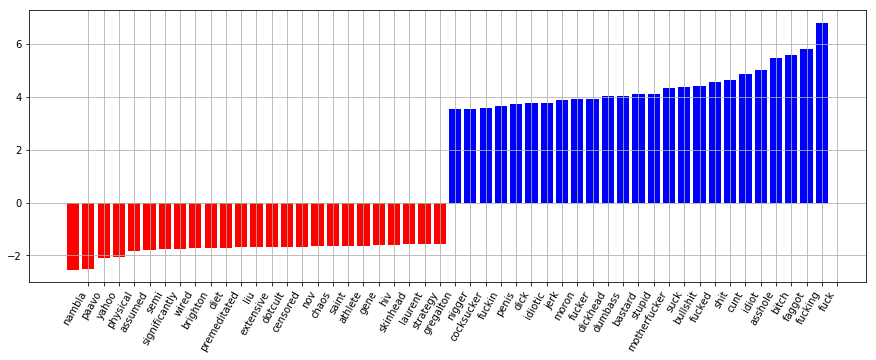

In [46]:
visualize_coefficients(model_cv, count_v.get_feature_names())

- N-граммы

In [47]:
# visualize_coefficients(model_cv_n, cv_ngram.get_feature_names())

Тут количество имен фичей настолько велико, что их не выходит разгрузить в nparray и соответственно график выходит без подписей

- TF-IDF

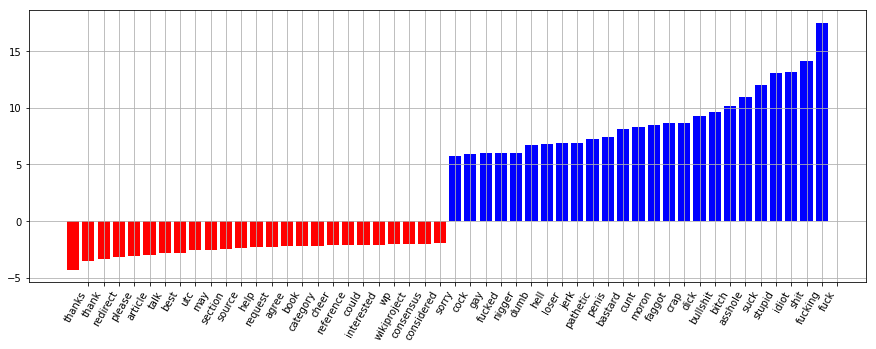

In [48]:
visualize_coefficients(model_tf_idf, count_tf_idf.get_feature_names())

В целом видно, что слова имеющие наибольший вес в обоих случаях похожи. По ругательствам очень хорошо можно определить тональность текста. Интересно, что для мешка слов отрицательный вес имеют случайные слова, видимо достаточно редко встречающиеся в текстах в принципе, и похоже совсем не встречающиеся в негативных записях. Это, конечно, не имеет большого смысла, ведь с подобными словами в других данных могут попасться и негативные отзывы. А вот в случае с TF-IDF вполне слова с низким коэффициентом модели вполне интерпретируются как положительные. 

# Вывод

Наилучшие результаты показало использоване N-граммов, состоящих из двух слов. Итоговая метрика F1 составила 0.7861, при уменьшении порога, при котором комментарии считаются токсичными. При этом другие модели (в особенности простой мешок слов, показывают примерно сопоставимое качество, однако обучаются значительно быстрее. 